# DSP - Aufgabenblatt 11

## Bewertete Übung

#### FHNW - HS2021

#### Vorgaben für die Zusammenarbeit

Ihr dürft für die Lösung der Übung zusammenarbeiten, so lange sich eure **Zusammenarbeit auf konzeptionelle und algorithmische Fragestellungen beschränkt**. Bei kopiertem Code oder Text (von Mitstudierenden oder dem Internet) werden alle Lösungen der beteiligten Parteien mit 0 Punkten bewertet. Dazu werden alle Lösungen manuell und automatisiert auf Kopien untersucht.  

#### Abgabe

Arbeite auf einem eigenen Fork des Repositories `https://gitlab.fhnw.ch/ml/courses/dsp/dsp_hs2021` zu welchem du @michael.graber und @florian.schaerer als *Maintainer* hinzufügst. Committe regelmässig. Als Abgabe gilt der **letzte Commit bis Freitag, 31. Dezember 2021, 23:59:59 Uhr**.

#### Hinweise
- Der *Code* muss von Anfang bis Ende durchlaufen. Es wird nur Code bewertet, welcher beim automatischen Durchlaufen ausgeführt wird.    
- Beschrifte sämtliche Achsen (Bezeichnung und Einheit wenn möglich).  
- Ergänze den Plot mit zusätzlicher Beschriftung falls dies zum Verständnis des Plots notwendig ist.  
- Wenn du einen Plot in einer Antwort diskutierst, beginne mit einer Beschreibung dessen was der Plot zeigt.  


- Sämtliche Variablen die in einer von dir definierten Funktionen verwendet werden, müssen als Argumente übergeben oder innerhalb der Funktion definiert werden.
- Selbst definierte Funktionen müssen einen (kurzen) docstring haben.


- Versuche eine kompakte und performante Implementierung zu finden. Vollständige Punktzahl erreichst du bloss mit performantem *Code*.  
- Verwende dazu, wo immer möglich und sinnvoll, Funktionen aus `pandas` und `numpy`.
- Vermeide *Loops* falls möglich.

Am 14. April 1912 ist die Titanic vor der Küste Neufundlands auf ihrer Jungfernfahrt mit einem Eisberg kollidiert und sank kanpp 3 Stunden später in den frühen Morgenstunden des 15. Aprils. Von den ca 2224 Passagieren und Crewmitgliedern starben rund 1500.  

Auf der Website https://www.encyclopedia-titanica.org/ können Passagier- und Crewlisten runtergeladen werden. Ich habe euch zwei Dateien bereitgestellt: 'data/titanic_survivors.csv' und 'data/titanic_victims.csv'. Sie beinhalten jeweils die Überlebenden und Opfer des Unglücks.  

Wir werden in dieser Übung die Personen hinter diesem Unglück miteinander untersuchen.

In [1]:
# imports
import pandas as pd
import numpy as np
import re as re
import matplotlib.pyplot as plt
import seaborn as sns

### Aufgabe 1 (10 Punkte)  

Schreibe eine Funktion, mit welcher du die beiden Dateien laden und präprozessieren kannst.  

Die Funktion soll ein `DataFrame` zurückgeben mit folgenden Spalten: `'name', 'sex', 'age', 'is_adult', 'job', 'class_dept', 'is_passenger', 'joined', 'boat_body', 'ticketprice', 'survived',`.  


- Der Ticketpreis steht bei Passagieren jeweils auf der folgenden Zeile im Feld `Ticket`. Extrahiere Pfund, Shilling und Pence mittels *regular expression-matching* auf dem `DataFrame`.
- Berechne einen Dezimalbetrag in Pfund gemäss dem folgenden Satz: *'There were 12 pence in a shilling and 20 shillings in a pound.'* 
- Leite das Geschlecht `sex` aus dem Namen, insbesondere aus der Anrede, ab. Finde eine geeignete `pandas`-Methode für das *Mapping*.
- Berechnene das Alter für alle Personen in Jahren (`m` steht für *months*).
- `is_passenger` soll `True` sein, falls `class_dept` in `['1st Class Passenger', '2nd Class Passenger', '3rd Class Passenger',]` ist.  
- Sortiere das `DataFrame` nach dem Familiennamen.

Jeder *for-Loop* gibt 2 Punkte Abzug.  

Lade die Daten und gib die ersten 10 Zeilen aus.

In [2]:
# load and process file
def load(filename):
    """ reads csv file, processes data to return it as a dataframe """
    
    # read csv as dataframe
    df = pd.read_csv(filename, skiprows=5, header=0)
    
    # create new empty dataframe
    result = pd.DataFrame(columns=["name", "sex", "age", "is_adult", "job", "class_dept", "is_passenger", "joined", "boat_body", "ticketprice", "survived"])
    
    # create a df for all people and all tickets
    people = df[df["Name"].notnull()]
    tickets = df[df["Name"].isnull() & df["Ticket"].notnull()]
    
    # fill columns
    result["name"] = people["Name"]
    result["sex"] = result["name"].apply(lambda name: sex(name))
    result["age"] = people["Age"].apply(lambda lifetime: age(lifetime))
    result["age"] = result["age"].fillna(-1).astype(int)  #fill nulls with -1 to convert column to dtype int
    result["is_adult"] = result["age"].apply(lambda age: isAdult(age))
    result["job"] = people["Job"]  
    result["class_dept"] = people["Class/Dept"]
    result["is_passenger"] = result["class_dept"].apply(lambda class_debt: isPassenger(class_debt))
    result["joined"] = people["Joined"]
    result["boat_body"] = people["Boat [Body]"]
    # re-index tickets
    tickets = tickets.set_index(tickets.index-1)
    result["ticketprice"] = tickets["Ticket"].apply(lambda price: ticketPrice(price))
    result["survived"] = True if "survivors" in filename else False
    
    # sort result by name
    result = result.sort_values(by="name")
    
    # reset indices for a gapless order 
    result = result.reset_index()
    result = result.drop(["index"], axis=1)
    
    # return new dataframe
    return result



# get sex by name
def sex(name):
    """ returns sex according to name salutation """
    #female = Ms | Mrs | Miss | Lady | Mlle | Sra. | ?
    #male = Mr | Sig. | Captain | Master | Colonel | ?
    femaleMatch = re.search(r'Ms|Mrs|Miss|Lady|Mlle|Sra\.', name) 
    if femaleMatch:
        return "Female"
    else:
        return "Male"

# get age
def age(lifetime):
    """ set ages conaining "m" (months) to 0 and returns age"""
    return lifetime if "m" not in str(lifetime) else 0

# check if adult (age >= 18)
def isAdult(age):
    """ returns True if age >= 18, and False if not """
    if(pd.notna(age)):
        return True if int(age) >= 18 else False
    else:
        #returns None
        return

# check if it's a passenger
def isPassenger(class_debt):
    """ returns if person is a passenger according to its class """
    isPassenger = class_debt in ["1st Class Passenger", "2nd Class Passenger", "3rd Class Passenger"]
    return isPassenger

# get ticketprice as float
def ticketPrice(price):
    """ computes ticketprice using regex, converts shillings and pences to decimal
    and returns final ticketprice as float """
    
    #regex matching for pound, shilling and pence
    pound = re.search(r'(£[0-9]*)', price).group().split("£")[1]
    shilling = re.search(r'([0-9]*s)', price)
    pence = re.search(r'([0-9]*d)', price)
    
    #init default after decimal
    afterDecimal = 0
    
    #convert shillings and pences to decimal
    if (shilling is not None):
        s = shilling.group().split("s")[0]
        afterDecimal += int(s)/20
    if (pence is not None):
        p = pence.group().split("d")[0]
        afterDecimal += int(p)/20/12
    
    #sum ticketprice
    ticketprice = int(pound) + afterDecimal
    
    #return as float
    return float(round(ticketprice, 2))



# load and process files    
victims = load('data/titanic_victims.csv')
survivors = load('data/titanic_survivors.csv')

# concat dataframes
allPersons = pd.concat([victims, survivors])

# display first ten persons
display(allPersons.head(10))

,name,sex,age,is_adult,job,class_dept,is_passenger,joined,boat_body,ticketprice,survived
0,"ABBING, Mr Anthony",Male,41,True,Blacksmith,3rd Class Passenger,True,Southampton,NaN,7.55,False
1,"ABBOTT, Mr Ernest Owen",Male,21,True,Lounge Pantry Steward,Victualling Crew,False,Southampton,NaN,NaN,False
2,"ABBOTT, Mr Eugene Joseph",Male,13,False,Scholar,3rd Class Passenger,True,Southampton,NaN,20.25,False
3,"ABBOTT, Mr Rossmore Edward",Male,16,False,Jeweller,3rd Class Passenger,True,Southampton,[190],20.25,False
4,"ABELSON, Mr Samuel",Male,30,True,NaN,2nd Class Passenger,True,Cherbourg,NaN,24.00,False
5,"ABRAMS, Mr William Thomas",Male,34,True,Fireman,Engineering Crew,False,Southampton,NaN,NaN,False
6,"ABĪ SA'B, Mr Jirjis Yūsuf",Male,45,True,Shoemaker,3rd Class Passenger,True,Cherbourg,[312],7.22,False
7,"ABĪ SHADĪD, Mr Dāhir",Male,19,True,NaN,3rd Class Passenger,True,Cherbourg,[9],7.22,False
8,"ADAMS, Mr John",Male,26,True,NaN,3rd Class Passenger,True,Southampton,[103],8.05,False
9,"ADAMS, Mr Robert John",Male,26,True,Fireman,Engineering Crew,False,Southampton,NaN,NaN,False


### Aufgabe 2 (8 Punkte)

Wieviele Personen sind es insgesamt?  

Wieviele Personen ohne Ticketpreis?  

Wieviele Personen ohne Altersangabe?  

Wieviele Personen männlichen und weiblichen Geschlechts fanden sich gemäss unserem Datensatz auf der Titanic?  

Wie viele Kinder, welchen Geschlechts?  

Was war der durchschnittliche Preis für eine Fahrkarte?  

Was war das Durchschnittsalter der Besatzungsmitglieder? Was war das Durchschnittsalter der Passagiere?

In [3]:
# get number of elements as string
def quantity(df):
    """ returns the number of elements of a dataframe as a string """
    return str(len(df))

# get rounded mean as string
def roundedMean(col, d):
    """ returns the mean value of a dataframe column rounded to 'd' decimals as a string """
    return str(np.around(np.mean(col), decimals=d))


# print answers
print("Anzahl Personen insgesamt: "+ quantity(allPersons))
print("Anzahl Personen ohne Ticketpreis: "+ quantity(allPersons[allPersons.ticketprice.isna()]))
print("   "+ quantity(allPersons[(allPersons.ticketprice.isna()) & (allPersons.is_passenger == False)])+" davon sind Besatzungsmitglieder," 
      +"und "+ quantity(allPersons[(allPersons.ticketprice.isna()) & (allPersons.is_passenger)])+" sind Passagiere")
print("Anzahl Personen ohne Altersangabe: "+quantity(allPersons[allPersons.age == -1]))
print(
    "Anzahl Männer: "+ quantity(allPersons[allPersons.sex == "Male"])+", "+ 
    "Anzahl Frauen: "+ quantity(allPersons[allPersons.sex == "Female"])
     )
print("Anzahl Kinder [Junge]: "+ quantity(allPersons[(allPersons.sex == "Male") & (allPersons.is_adult == False)]))
print("Anzahl Kinder [Mädchen]: "+ quantity(allPersons[(allPersons.sex == "Female") & (allPersons.is_adult == False)]))
print("Durchschnittlicher Ticketpreis (gerundet): "+ roundedMean(allPersons["ticketprice"], 2))
print("Durchschnittsalter der Besatzungsmitglieder (gerundet): "+ roundedMean(allPersons.age[allPersons.is_passenger == False], 0))
print("Durchschnittsalter der Passagiere (gerundet): "+ roundedMean(allPersons.age[allPersons.is_passenger], 0))

Anzahl Personen insgesamt: 2208
Anzahl Personen ohne Ticketpreis: 917
   891 davon sind Besatzungsmitglieder,und 26 sind Passagiere
Anzahl Personen ohne Altersangabe: 3
Anzahl Männer: 1723, Anzahl Frauen: 485
Anzahl Kinder [Junge]: 124
Anzahl Kinder [Mädchen]: 82
Durchschnittlicher Ticketpreis (gerundet): 33.76
Durchschnittsalter der Besatzungsmitglieder (gerundet): 32.0
Durchschnittsalter der Passagiere (gerundet): 30.0


### Aufgabe 3 (3 Punkte)

Erstelle eine Kreuztabelle von Einstiegsort und `class_dept`.  

Visualisiere die Tabelle.  
Wir wissen, dass die Titanic von *Belfast*, wo sie gebaut wurde, nach *Southhampton*, nach *Cherbourg* und dann nach *Queenstown* fuhr, bevor sie zur Atlantiküberfahrt auslief.  

Diskutiere deine Erkenntnisse.

joined,Belfast,Cherbourg,Queenstown,Southampton
class_dept,,,,
1st Class Passenger,4,143,3,174
2nd Class Passenger,6,26,7,245
3rd Class Passenger,0,102,113,494
Deck Crew,24,0,0,42
Engineering Crew,44,0,0,281
Restaurant Staff,0,0,0,69
Victualling Crew,122,0,0,309


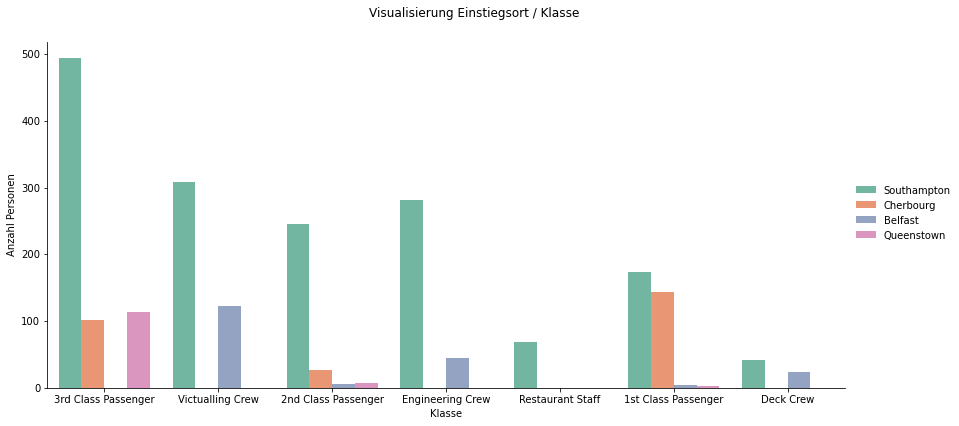

In [4]:
# create cross table
joined = allPersons["joined"]
class_dept = allPersons["class_dept"]
crossTable = pd.crosstab(class_dept, joined)

# display cross table
display(crossTable)

# visualize joined / class_dept as catplot
g = sns.catplot(
    data=allPersons, kind="count",
    x="class_dept", hue="joined",
    palette=sns.color_palette("Set2"),
    ci=None, height=6, aspect=2, margin_titles=False
)
_ = g.set_axis_labels("Klasse", "Anzahl Personen")
_ = g.legend.set_title("")
_ = g.fig.subplots_adjust(top=0.9) 
_ = g.fig.suptitle("Visualisierung Einstiegsort / Klasse")

Die Kreuztabelle sowie die Visualisierung zeigen gut auf, dass die meisten Menschen in Southampton einstiegen. Vorallem die Besatzungsmitglieder stiegen ausschliesslich in Belfast oder Southampton ein. Ausserdem gab es fast keine Passagiere die in Belfast einstiegen.

### Aufgabe 4 (5 Punkte)

Visualisiere die Altersverteilung für die beiden Geschlechter und gleichzeitig für die Variable `class_dept` mit Boxplots.  

Diskutiere die Visualisierung.
- Erkläre was ein Boxplot zeigt.
- Was für Information fehlt?
- Was können wir zu den vorliegenden Daten aus dieser Darstellung lesen?

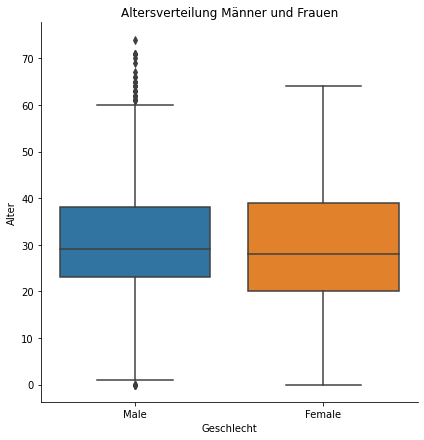

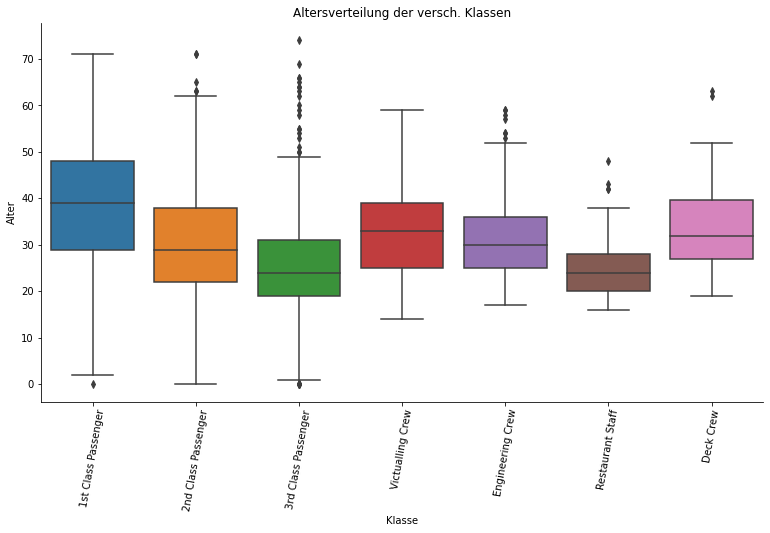

In [5]:
# only plot people where age not null (ignoring -1's)
allPersons_ageNotNa = allPersons[allPersons.age >= 0]

# boxplot age distribution of male and female
g = sns.catplot(data=allPersons_ageNotNa, x="sex", y="age", kind="box", height=6, aspect=1)
_ = g.set(xlabel='Geschlecht', ylabel='Alter', title="Altersverteilung Männer und Frauen")

# class_dept order 
x_order = ["1st Class Passenger", "2nd Class Passenger", "3rd Class Passenger", "Victualling Crew", "Engineering Crew", "Restaurant Staff", "Deck Crew"]

# boxplot age distribution of diff classes
h = sns.catplot(data=allPersons_ageNotNa, x="class_dept", y="age", kind="box", order=x_order, height=6, aspect=1.8)
_ = h.set(xlabel='Klasse', ylabel='Alter', title="Altersverteilung der versch. Klassen")
_ = h.set_xticklabels(rotation=80)

Ein Boxplot zeigt schnell auf in welchen Bereichen die Daten liegen. Dabei wird das Minimum, das untere Quartil, der Median, das obere Quartil und das Maximum der Daten abgebildet abgebildet - die Punkte ausserhalb des Minimum und Maximum stellen die Ausreisser dar. <br>Aus der Visualisierung "Altersverteilung der versch. Klassen" ist ersichtlich, dass das Alter mit tiefem Ticketpreis immer kleiner wird. Daraus kann man entnehmen, dass das Alter mit dem Vermögen einer Person zusammenhängt - ältere Personen (mit wahrscheinlich grösserem Vermögen) konnten sich teurere Tickets leisten. Für genauere Angaben fehlen hier jedoch die einzelnen Ticketpreise.

### Aufgabe 5 (4 Punkte)

Zeichne die Verteilung des Alters sämtlicher Passagiere als Histogramm.  

Beschreibe die Verteilung bezüglich Lage, Streuung und Form.  

Du darfst verschiedene Ansätze verwenden und deren Resultate und Eigenschaften diskutieren.

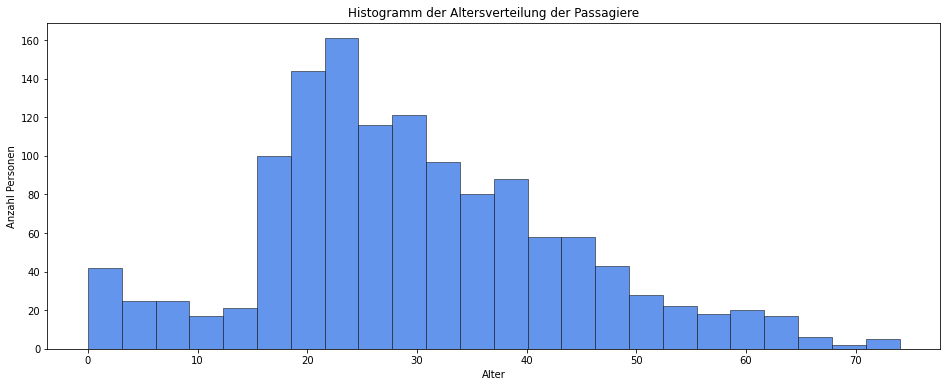

In [14]:
# age distribution histogram
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,6))
_ = ax.hist(allPersons_ageNotNa.age[allPersons_ageNotNa.is_passenger], bins="fd", color="cornflowerblue", edgecolor="black", linewidth=0.5)
_ = ax.set_title("Histogramm der Altersverteilung der Passagiere")
# show histogram labels
_ = ax.set_ylabel("Anzahl Personen")
_ = ax.set_xlabel("Alter")

### Lage

In [7]:
print("Median: "+ str(np.median(allPersons_ageNotNa.age[allPersons_ageNotNa.is_passenger])))
print("Mittelwert: "+ roundedMean(allPersons_ageNotNa.age[allPersons_ageNotNa.is_passenger], 2))
print("Q0.25-Quantil: "+ str(allPersons_ageNotNa.age[allPersons_ageNotNa.is_passenger].quantile(0.25)))
print("Q0.75-Quantil: "+ str(allPersons_ageNotNa.age[allPersons_ageNotNa.is_passenger].quantile(0.75)))

Median: 28.0
Mittelwert: 29.63
Q0.25-Quantil: 21.0
Q0.75-Quantil: 38.0


### Streuung

In [8]:
print("Quantil Differenz: "+ str(allPersons_ageNotNa.age[allPersons_ageNotNa.is_passenger].quantile(0.75) - allPersons_ageNotNa.age[allPersons_ageNotNa.is_passenger].quantile(0.25)))
print("Standardabweichung: "+ str(round(allPersons_ageNotNa.age[allPersons_ageNotNa.is_passenger].std(), 2)))
print("Varianz: "+ str(round(allPersons_ageNotNa.age[allPersons_ageNotNa.is_passenger].var(), 2)))

Quantil Differenz: 17.0
Standardabweichung: 13.91
Varianz: 193.44


### Form

In [9]:
print("Schiefe: "+ str(round(allPersons_ageNotNa.age[allPersons_ageNotNa.is_passenger].skew(), 2)) + " (leicht rechtsschief)")

Schiefe: 0.42 (leicht rechtsschief)


Hier ist es gut ersichtlich dass sich die Verteilung vorallem auf Personen mittleren alters (20-40) konzentriert.

### Aufgabe 6 (3 Punkte)

Führe die Schritte aus Aufgabe 5 für den Ticketpreis aus.  

Visualisiere zusätzlich die kumulative Verteilung.  

Diskutiere deine Erkenntnisse.

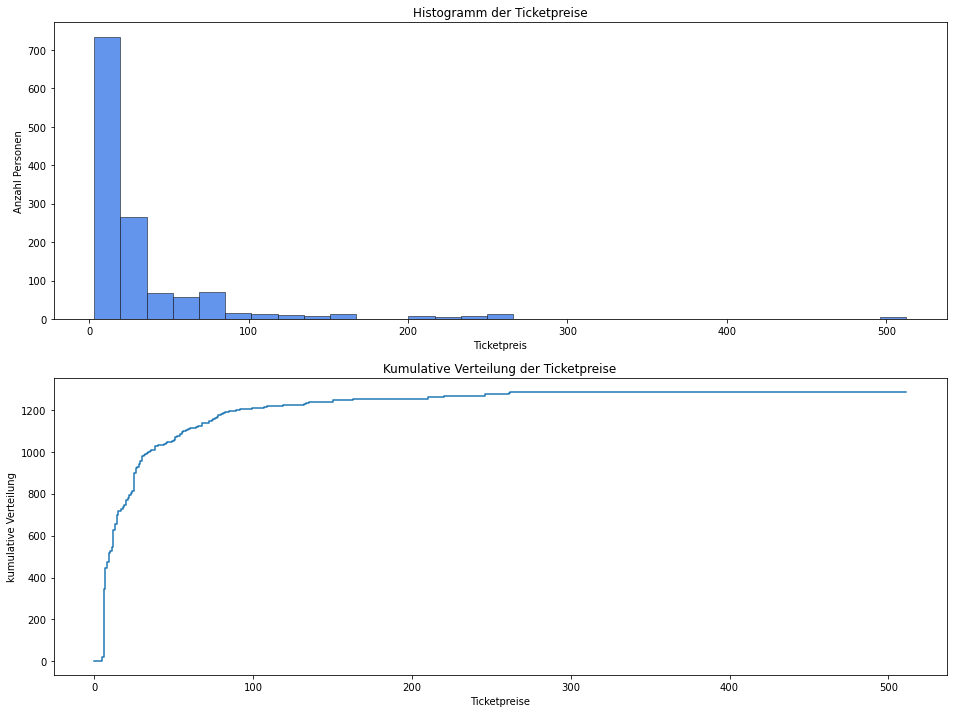

In [15]:
# cum dist
def cum_dist(a):
    """ computes cumulative distribution 
    and returns x and y values for the step-function """
    max_value = int(np.max(a)) 
    x = np.arange(max_value)
    y = np.cumsum(np.histogram(a, max_value, range=(0,max_value))[0])
    return x, y

# histogram
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16,12))
_ = ax[0].hist(allPersons["ticketprice"], bins="scott", color="cornflowerblue", edgecolor="black", linewidth=0.5)
_ = ax[0].set_title("Histogramm der Ticketpreise")
# show histogram labels
_ = ax[0].set_ylabel("Anzahl Personen")
_ = ax[0].set_xlabel("Ticketpreis")

# cum dist as step function
cd_x, cd_y = cum_dist(allPersons["ticketprice"])
_ = ax[1].step(cd_x, cd_y)
_ = ax[1].set_title("Kumulative Verteilung der Ticketpreise")
_ = ax[1].set_ylabel("kumulative Verteilung")
_ = ax[1].set_xlabel("Ticketpreise") 

#lage
ticketprice_median = np.median(allPersons["ticketprice"])
ticketprice_mean = np.mean(allPersons["ticketprice"]) #33.75
ticketprice_q25 = allPersons["ticketprice"].quantile(0.25) #7.92
ticketprice_q75 = allPersons["ticketprice"].quantile(0.75) #31.33

#streuung
ticketprice_q_diff = allPersons["ticketprice"].quantile(0.75) - allPersons["ticketprice"].quantile(0.25) #23.41
ticketprice_std = allPersons["ticketprice"].std() #52.225
ticketprice_var = allPersons["ticketprice"].var() #2727.49

#form
ticketprice_skew = allPersons["ticketprice"].skew() #4.350

Schiefe = 4.350<br>
Die Verteilung ist somit stark rechtsschief - was vorallem an den Passagieren mit "3rd Class Passenger" und sehr günstigen Ticketpreisen liegt.

### Aufgabe 7 (3 Punkte)

Was sind die häufigsten 10 Berufe der Passagiere, welche oberhalb des $Q_{0.9}$-Quantils des Ticketpreises liegen?  

Was sind die häufigsten 10 Berufe der Passagiere, welche unterhalb des $Q_{0.1}$-Quantils des Ticketpreises liegen?  

Wie oft kommen die Berufe jeweils vor?  
Wie interpretierst du das Resultat?

In [11]:
# all persons above the Q0.9-quantile ticketprice
personsQ09 = allPersons[allPersons.ticketprice > allPersons.ticketprice.quantile(.9)]
# all persons below the Q0.1-quantile ticketprice
personsQ01 = allPersons[allPersons.ticketprice < allPersons.ticketprice.quantile(.1)]

# return df with top 10 jobs based on their counts
def mostFrequentJobs(df):
    """ returns top 10 frequent jobs based on their count as new dataframe """
    # create new df with all jobs and their counts
    allJobs = pd.DataFrame(columns=["job", "count"])
    allJobs["job"] = df["job"]
    allJobs["count"] = allJobs.groupby("job")["job"].transform("count")
    # drop unnecessary duplicates
    allJobs.drop_duplicates(inplace=True)
    # sort jobs by their counts - descending
    allJobs = allJobs.sort_values(by=["count"], ascending=False)
    # re-set indices as top 10
    allJobs.index = np.arange(1, len(allJobs)+1)
    
    #return first ten jobs
    return allJobs.head(10)

# display answers
print("Die 10 häufigsten Jobs, mit Tickpreis oberhalb des Q0.9-Quantils: ")
display(mostFrequentJobs(personsQ09[personsQ09.is_passenger]))
print("\nDie 10 häufigsten Jobs, mit Ticketpreis unterhalb des Q0.1-Quantils: ")
display(mostFrequentJobs(personsQ01[personsQ01.is_passenger]))

Die 10 häufigsten Jobs, mit Tickpreis oberhalb des Q0.9-Quantils: 


,job,count
1,Personal Maid,16.0
2,Servant,6.0
3,Of Independent Means,6.0
4,Businessman,5.0
5,Merchant,2.0
6,Nursemaid,2.0
7,Governess,2.0
8,Doctor,1.0
9,Nurse,1.0
10,Politician,1.0



Die 10 häufigsten Jobs, mit Ticketpreis unterhalb des Q0.1-Quantils: 


,job,count
1,General Labourer,28.0
2,Farmer,18.0
3,Farm Labourer,11.0
4,Carpenter / Joiner,4.0
5,Dealer,3.0
6,Journalist,2.0
7,Shoemaker,2.0
8,Scholar,1.0
9,Bricklayer,1.0
10,Dairy Worker,1.0


Die 10 häufigsten Berufe oberhalb des Q0.9-Quantils und unterhalb des Q0.1-Quantils und deren Anzahl sind in den obigen Tabellen ersichtlich. Bei den Tabellen fällt auf dass vorallem Diener und Haushälter die teuersten und allgmeine Hilfskräfte und Farmer die billigsten Ticketpreise bezahlten. Doch vorallem auch hochangesehene (und wahrscheinlich auch gut verdienende) Jobs wie Doktor, Geschäftsmann und Poltiker zahlten die teuersten Ticketpreise. Und geringere Berufe (mit wahrscheinlich geringerem Lohn) wie Maurer, Schuhmacher oder Molkereiarbeiter zahlten die günstigsten Ticketpreise.

### Aufgabe 8 (6 Punkte)

Finde ein paar wenige Visualisierungen, welche es ermöglichen, kompakt einen Eindruck zu bekommen, wer das Unglück der Titanic am wahrscheinlichsten überlebt hat.  

Was sind deine Erkenntnisse?

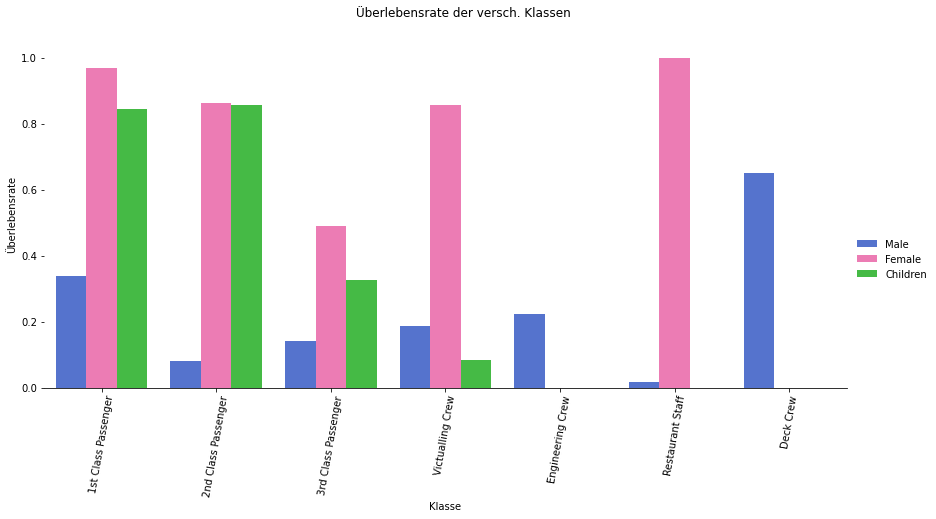

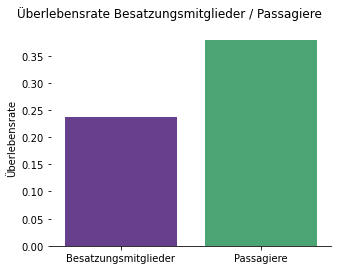

In [12]:
# adjust df: add column 'kind' to distinguish between Male, Female & Children (only for this visualization!)
allPersons["kind"] = allPersons.apply(lambda person: person.sex if person["is_adult"] == True else "Children", axis=1)

# survival rate by class_dept and sex (male, female, children)
g = sns.catplot(
    data=allPersons, kind="bar",
    x="class_dept", y="survived", hue="kind", hue_order=["Male", "Female", "Children"], order=x_order,
    palette=sns.color_palette(['royalblue', 'hotpink', 'limegreen']),
    ci=None, height=6, aspect=2, margin_titles=False
)
_ = g.despine(left=True) #remove left spine
_ = g.set_axis_labels("Klasse", "Überlebensrate")
_ = g.set_xticklabels(rotation=80)
_ = g.legend.set_title("")
_ = g.fig.subplots_adjust(top=0.9) # adjust facet grid
_ = g.fig.suptitle("Überlebensrate der versch. Klassen")


# drop column 'kind' again
allPersons.drop('kind', axis=1, inplace=True)


# survival rate crew / passenger
h = sns.catplot(
    data=allPersons, kind="bar",
    x="is_passenger", y="survived",
    palette=sns.color_palette(['rebeccapurple', 'mediumseagreen']),
    ci=None, height=4, aspect=1.2, margin_titles=False
)
_ = h.despine(left=True) #remove left spine
_ = h.set_axis_labels("", "Überlebensrate")
_ = h.fig.subplots_adjust(top=0.9) 
_ = h.set(xticklabels=["Besatzungsmitglieder", "Passagiere"])
_ = h.fig.suptitle("Überlebensrate Besatzungsmitglieder / Passagiere")

Die obige Visualisierung "Überlebensrate der versch. Klassen" zeigt gut auf dass vorallem Frauen und Kinder die besseren Überlebenschance hatten, und Männer die geringeren (woran das liegt kann nur spekuliert werden). Ebenfalls zeigt die Visualisierung auf, dass lediglich Männer zur Engineering und Deck Crew angehörten, und vorallem Frauen zum Restaurant Staff (auch wenn dies nicht Ziel der Visualisierung war). Ausserdem zeigt die Visualisierung dass im allgemeinen Passagiere eine bessere Überlebenschance hatten als die Besatzungsmitglieder - Visualisierung 2 "Überlebensrate Besatzungsmitglieder/Passagiere" zeigt dies nochmals genauer.

### Aufgabe 9 (6 Punkte)

Untersuche nun, ob das Alter einen Einfluss auf die Überlebenswahrscheinlichkeit hatte.  

Teile die Passagiere dazu in Gruppen von Geschlecht und Altersjahrzenten ein.  

Visualisiere die Resultate übersichtlich und diskutiere diese.  

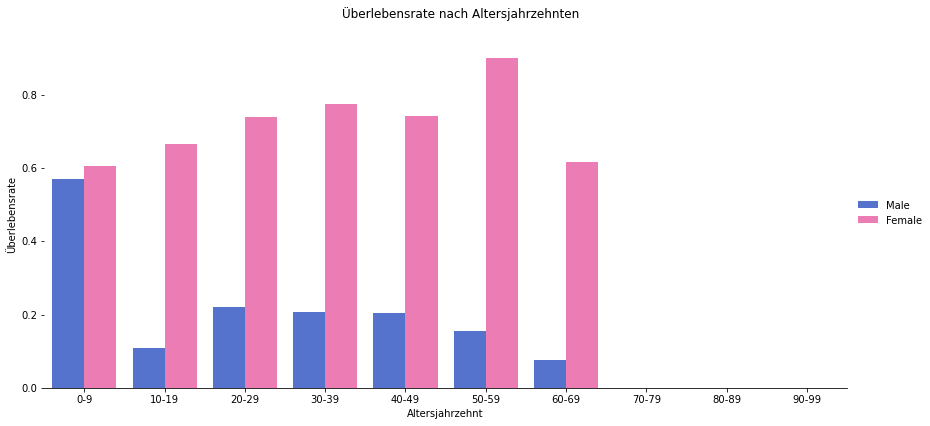

In [13]:
# segment ages in bins 
labels = ["0-9", "10-19", "20-29", "30-39", "40-49", "50-59", "60-69", "70-79", "80-89", "90-99"]
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
allPersons["age_decade"] = pd.cut(allPersons["age"], bins=bins, labels=labels, right=False)

# survival rate by age_decade and sex
g = sns.catplot(x="age_decade", y="survived", hue="sex",
                data=allPersons, kind="bar", 
                palette=sns.color_palette(['royalblue', 'hotpink']),
                ci=None, height=6, aspect=2, margin_titles=False
               )
_ = g.despine(left=True) #remove left spine
_ = g.set_axis_labels("Altersjahrzehnt", "Überlebensrate")
_ = g.legend.set_title("")
_ = g.fig.subplots_adjust(top=0.9) 
_ = g.fig.suptitle("Überlebensrate nach Altersjahrzehnten")

Aus Sicht der Geschlechter hatten die Frauen überwiegend in allen Altersklassen die besseren Überlebenschancen - lediglich bei Kindern im ersten Altersjahrzehnt sind die Überlebenschancen von Jungs und Mädchen in etwa gleich. Die Visulisierung zeigt dass wie bei Aufgabe 8 erwähnt, die Kinder die besten Überlebenschancen hatten. Erwachsene Männer hatten überwiegend schlechte Überlebenschancen (die grössten Chancen hatten dabei junge Erwachsene in den 20er Jahren - danach nimmt die Überlebenschance von Jahrzehnt zu Jahrzehnt ab) 

## Schlussbemerkung

Für das Lösen der Aufgaben wurden ausschliesslich die Pandas und Numpy-Dokumentation verwendet. Lediglich zur Darstellung und Anpassung von Plots und zum Verständnis von Pandas.Cut wurde teilweise StackOverflow verwendet, um schneller eine Lösung zu finden.
StackOverflow-Links: 
<ul>
    <li> https://stackoverflow.com/questions/29813694/how-to-add-a-title-to-seaborn-facet-plot </li>
    <li> https://stackoverflow.com/questions/45751390/pandas-how-to-use-pd-cut </li>
</ul>